# Model Selection: Choosing Estimators and Their Parameters

![Cross-validation](./img/cross_validation.jpg)

### Score, and Cross-validated Scores

> As we have seen, every estimator exposes a score method that can judge the quality of the fit (or the prediction) on new data. Bigger is better.

In [1]:
from sklearn import datasets, svm

digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

svc = svm.SVC(C=1, kernel='linear')
svc.fit(X_digits[:-100], y_digits[:-100]).score(X_digits[-100:], y_digits[-100:])

0.97999999999999998

__k-fold Cross-validation__: [look here](https://en.wikipedia.org/wiki/Cross-validation_(statistics)

> To get a better measure of prediction accuracy (which we can use as a proxy for goodness of fit of the model), we can successively split the data in folds that we use for training and testing.

In [3]:
# Using k-fold cross-validation
import numpy as np

X_folds = np.array_split(X_digits, 3)
y_folds = np.array_split(y_digits, 3)
scores = list()

for k in range(3):
    # We use 'list' to copy, in order to 'pop' later on
    X_train = list(X_folds)
    X_test  = X_train.pop(k)
    X_train = np.concatenate(X_train)
    y_train = list(y_folds)
    y_test  = y_train.pop(k)
    y_train = np.concatenate(y_train)
    scores.append(svc.fit(X_train, y_train).score(X_test, y_test))

print(scores)

[0.93489148580968284, 0.95659432387312182, 0.93989983305509184]


### Cross-validation generators

> The code above to split data in train and test sets is tedious to write. Scikit-learn exposes cross-validation generators to generate list of indices for this purpose:

In [6]:
from sklearn import cross_validation

k_fold = cross_validation.KFold(n=6, n_folds=3)

for train_indices, test_indices in k_fold:
     print('Train: %s | test: %s' % (train_indices, test_indices))

Train: [2 3 4 5] | test: [0 1]
Train: [0 1 4 5] | test: [2 3]
Train: [0 1 2 3] | test: [4 5]


In [10]:
# The cross-validation can then be implemented easily
kfold = cross_validation.KFold(len(X_digits), n_folds=3)

[svc.fit(X_digits[train], y_digits[train]).score(X_digits[test], y_digits[test])
    for train, test in kfold]

[0.93489148580968284, 0.95659432387312182, 0.93989983305509184]

In [11]:
# To compute the score method of an estimator, the sklearn exposes a helper function
cross_validation.cross_val_score(svc, X_digits, y_digits, cv=kfold, n_jobs=-1)

array([ 0.93489149,  0.95659432,  0.93989983])

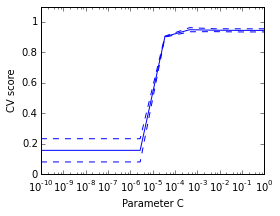

In [13]:
# Using Cross-validation with an SVM on the Digits dataset
import numpy as np
from sklearn import cross_validation, datasets, svm
%matplotlib inline

digits = datasets.load_digits()
X = digits.data
y = digits.target

svc = svm.SVC(kernel='linear')
C_s = np.logspace(-10, 0, 10)

scores = list()
scores_std = list()
for C in C_s:
    svc.C = C
    this_scores = cross_validation.cross_val_score(svc, X, y, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

# Do the plotting
import matplotlib.pyplot as plt
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.semilogx(C_s, scores)
plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
plt.ylim(0, 1.1)
plt.show()

### Grid Search and Cross-validated Estimators

__Grid Search__: [look here](https://en.wikipedia.org/wiki/Hyperparameter_optimization)

> The sklearn provides an object that, given data, computes the score during the fit of an estimator on a parameter grid and chooses the parameters to maximize the cross-validation score. This object takes an estimator during the construction and exposes an estimator API.

In [14]:
from sklearn.grid_search import GridSearchCV
Cs = np.logspace(-6, -1, 10)
clf = GridSearchCV(estimator=svc, param_grid=dict(C=Cs),
    n_jobs=-1)
clf.fit(X_digits[:1000], y_digits[:1000])

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=-1,
       param_grid={'C': array([  1.00000e-06,   3.59381e-06,   1.29155e-05,   4.64159e-05,
         1.66810e-04,   5.99484e-04,   2.15443e-03,   7.74264e-03,
         2.78256e-02,   1.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [15]:
clf.best_score_

0.92500000000000004

In [16]:
clf.best_estimator_.C

0.0077426368268112772

In [17]:
# Prediction performance on test set is not as good as on train set
clf.score(X_digits[1000:], y_digits[1000:]) 

0.94353826850690092

__Nested Cross-validation__

> Two cross-validation loops are performed in parallel: one by the GridSearchCV estimator to set gamma and the other one by cross_val_score to measure the prediction performance of the estimator. The resulting scores are unbiased estimates of the prediction score on new data.

In [18]:
cross_validation.cross_val_score(clf, X_digits, y_digits)

array([ 0.93853821,  0.96327212,  0.94463087])

__Cross-validated Estimators__

> Cross-validation to set a parameter can be done more efficiently on an algorithm-by-algorithm basis. This is why for certain estimators the sklearn exposes Cross-validation: evaluating estimator performance estimators that set their parameter automatically by cross-validation.

> These estimators are called similarly to their counterparts, with ‘CV’ appended to their name.

In [20]:
from sklearn import linear_model, datasets

diabetes = datasets.load_diabetes()
X_diabetes = diabetes.data
y_diabetes = diabetes.target

lasso = linear_model.LassoCV()
lasso.fit(X_diabetes, y_diabetes)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

# Unsupervised Learning: Seeking Representations of the Data

![Clustering](./img/clustering.jpg)

### Clustering: grouping observations together

For more, see [here](https://en.wikipedia.org/wiki/Cluster_analysis).

__Problem Solving with Clustering__

> Given the iris dataset, if we knew that there were 3 types of iris, but did not have access to a taxonomist to label them: we could try a clustering task: split the observations into well-separated group called clusters.

__k-Means Clustering__: [look here](https://en.wikipedia.org/wiki/K-means_clustering)

> Note that there exist a lot of different clustering criteria and associated algorithms. The simplest clustering algorithm is K-means.

> There is absolutely no guarantee of recovering a ground truth... don’t over-interpret clustering results.

In [2]:
from sklearn import cluster, datasets

iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target

k_means = cluster.KMeans(n_clusters=3)
k_means.fit(X_iris)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [3]:
# Clusters
print(k_means.labels_[::10])

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]


In [4]:
# Actual classes
print(y_iris[::10])

[0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]


__Vector Quantization__: [look here](https://en.wikipedia.org/wiki/Vector_quantization)

> Clustering in general and KMeans, in particular, can be seen as a way of choosing a small number of exemplars to compress the information. The problem is sometimes known as vector quantization. For instance, this can be used to posterize an image.

In [7]:
import scipy as sp
import numpy as np

try:
   lena = sp.lena()
except AttributeError:
   from scipy import misc
   lena = misc.lena()

X = lena.reshape((-1, 1)) # We need an (n_sample, n_feature) array
k_means = cluster.KMeans(n_clusters=5, n_init=1)
k_means.fit(X)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=1,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [8]:
values = k_means.cluster_centers_.squeeze()
labels = k_means.labels_
lena_compressed = np.choose(labels, values)
lena_compressed.shape = lena.shape

__Hierarchical Clustering: Ward__

* _Agglomerative_: Bottom up
* _Divisive_: Top down

__Connectivity-constrained Clustering__

> With agglomerative clustering, it is possible to specify which samples can be clustered together by giving a connectivity graph. Graphs in the scikit are represented by their adjacency matrix. Often, a sparse matrix is used. This can be useful, for instance, to retrieve connected regions (sometimes also referred to as connected components) when clustering an image.

In [10]:
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import AgglomerativeClustering
import time

# Generate data
lena = sp.misc.lena()

# Downsample the image by a factor of 4
lena = lena[::2, ::2] + lena[1::2, ::2] + lena[::2, 1::2] + lena[1::2, 1::2]
X = np.reshape(lena, (-1, 1))

# Define the structure A of the data. Pixels connected to their neighbors.
connectivity = grid_to_graph(*lena.shape)

# Compute clustering
print("Compute structured hierarchical clustering...")
st = time.time()
n_clusters = 15  # number of regions
ward = AgglomerativeClustering(n_clusters=n_clusters, 
    linkage='ward', connectivity=connectivity).fit(X)
label = np.reshape(ward.labels_, lena.shape)

# Output results.
print("Elapsed time: ", time.time() - st)
print("Number of pixels: ", label.size)
print("Number of clusters: ", np.unique(label).size)

Compute structured hierarchical clustering...
('Elapsed time: ', 10.0781090259552)
('Number of pixels: ', 65536)
('Number of clusters: ', 15)


__Feature Agglomeration__

> We have seen that sparsity could be used to mitigate the curse of dimensionality, i.e an insufficient amount of observations compared to the number of features. Another approach is to merge together similar features: feature agglomeration. This approach can be implemented by clustering in the feature direction, in other words clustering the transposed data.

In [11]:
digits = datasets.load_digits()
images = digits.images
X = np.reshape(images, (len(images), -1))
connectivity = grid_to_graph(*images[0].shape)

agglo = cluster.FeatureAgglomeration(connectivity=connectivity, n_clusters=32)
agglo.fit(X)

FeatureAgglomeration(affinity='euclidean', compute_full_tree='auto',
           connectivity=<64x64 sparse matrix of type '<type 'numpy.int64'>'
	with 288 stored elements in COOrdinate format>,
           linkage='ward', memory=Memory(cachedir=None), n_clusters=32,
           n_components=None,
           pooling_func=<function mean at 0x7f076812aa28>)

In [12]:
X_reduced = agglo.transform(X)
X_approx = agglo.inverse_transform(X_reduced)
images_approx = np.reshape(X_approx, images.shape)

__Principal Component Analysis (PCA)__: [look here](https://en.wikipedia.org/wiki/Principal_component_analysis)

> Principal component analysis (PCA) selects the successive components that explain the maximum variance in the signal.

In [13]:
# When used to transform data, PCA can reduce the dimensionality of the data by 
# projecting on a principal subspace.

# Create a signal with only 2 useful dimensions
x1 = np.random.normal(size=100)
x2 = np.random.normal(size=100)
x3 = x1 + x2
X = np.c_[x1, x2, x3]

from sklearn import decomposition
pca = decomposition.PCA()
pca.fit(X)

PCA(copy=True, n_components=None, whiten=False)

In [14]:
print(pca.explained_variance_)

[  3.09943175e+00   6.21013970e-01   2.47599660e-32]


In [15]:
# As we can see, only the 2 first components are useful
pca.n_components = 2
X_reduced = pca.fit_transform(X)
X_reduced.shape

(100, 2)

__Independent Component Analysis (ICA)__: [look here](https://en.wikipedia.org/wiki/Independent_component_analysis)

> Independent component analysis (ICA) selects components so that the distribution of their loadings carries a maximum amount of independent information. It is able to recover non-Gaussian independent signals.

In [16]:
# Generate sample data
time = np.linspace(0, 10, 2000)
s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
S = np.c_[s1, s2]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise
S /= S.std(axis=0)  # Standardize data

# Mix data
A = np.array([[1, 1], [0.5, 2]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

# Compute ICA
ica = decomposition.FastICA()
S_ = ica.fit_transform(X)  # Get the estimated sources
A_ = ica.mixing_.T
np.allclose(X,  np.dot(S_, A_) + ica.mean_)

True